In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from sksurv.datasets import load_breast_cancer
from sksurv.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from required_functions import cox_model_cop

In [2]:
X, Y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)


In [3]:
cols_list = Xt.columns.tolist()
print(cols_list)

['X200726_at', 'X200965_s_at', 'X201068_s_at', 'X201091_s_at', 'X201288_at', 'X201368_at', 'X201663_s_at', 'X201664_at', 'X202239_at', 'X202240_at', 'X202418_at', 'X202687_s_at', 'X203306_s_at', 'X203391_at', 'X204014_at', 'X204015_s_at', 'X204073_s_at', 'X204218_at', 'X204540_at', 'X204631_at', 'X204740_at', 'X204768_s_at', 'X204888_s_at', 'X205034_at', 'X205848_at', 'X206295_at', 'X207118_s_at', 'X208180_s_at', 'X208683_at', 'X209500_x_at', 'X209524_at', 'X209835_x_at', 'X209862_s_at', 'X210028_s_at', 'X210314_x_at', 'X210593_at', 'X211040_x_at', 'X211382_s_at', 'X211762_s_at', 'X211779_x_at', 'X212014_x_at', 'X212567_s_at', 'X214806_at', 'X214915_at', 'X214919_s_at', 'X215510_at', 'X215633_x_at', 'X216010_x_at', 'X216103_at', 'X216693_x_at', 'X217019_at', 'X217102_at', 'X217404_s_at', 'X217471_at', 'X217767_at', 'X217771_at', 'X217815_at', 'X218430_s_at', 'X218478_s_at', 'X218533_s_at', 'X218782_s_at', 'X218883_s_at', 'X218914_at', 'X219340_s_at', 'X219510_at', 'X219588_s_at', 'X219

In [4]:

t = np.array([ Y[i][1] for i in range(len(Y))], float)
c = np.array([Y[i][0] for i in range(len(Y))], int)
x = Xt.to_numpy()
x = np.array(x, float)

n, p = np.shape(x)

In [5]:
# import numpy.random as rnd
# ratio_train = 0.8
# idx_train = rnd.randint(0, len(t), size = int(ratio_train * n))
# t_train = t[idx_train]
# c_train = c[idx_train]
# x_train = x[idx_train, :]
# x_train = StandardScaler().fit_transform(x_train)


In [6]:
alphas = np.exp(np.linspace(np.log(4.0), np.log(0.5), 100))
cox_m = cox_model_cop(p, alphas)
cox_m.fit(t, c, x)
cox_m.compute_cv_loss(verbose = True)


KeyboardInterrupt: 

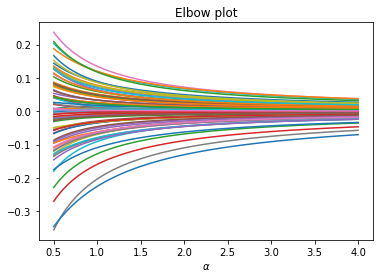

In [63]:
plt.figure()
plt.title('Elbow plot')
plt.plot(alphas, cox_m.betas)
plt.xlabel(r'$\alpha$')
plt.savefig('elbow_plot_application.png')

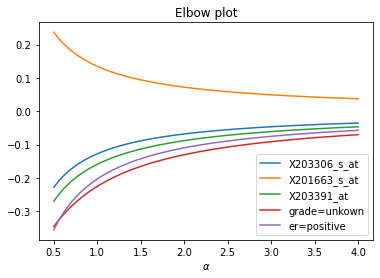

In [84]:
idx = np.argsort(np.abs(cox_m.betas[-1, :]))
# top_coeffs_names =  [cols_list[i] for i in idx[:5]]

plt.figure()
plt.title('Elbow plot')
for i in idx[-5:]:
    plt.plot(alphas, cox_m.betas[:,i], label = cols_list[i])
plt.xlabel(r'$\alpha$')
plt.legend()
plt.savefig('elbow_plot_application.png')

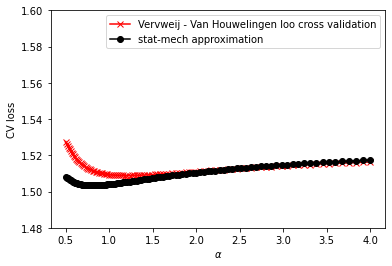

In [65]:
plt.figure()
plt.plot(alphas, cox_m.cv_loss, 'r-x', label = 'Vervweij - Van Houwelingen loo cross validation')
plt.plot(alphas, cox_m.approx_loo_loss, 'k-o', label = 'stat-mech approximation')
plt.legend()
plt.ylabel('CV loss')
plt.xlabel(r'$\alpha$')
plt.ylim(bottom = 1.48, top = 1.6)
plt.savefig('cox_cv_loss_application.png')

In [66]:
vals = np.arange(0.01, 2.0, 0.01)
tic = time.time()
cox_m.estimate_theta(vals)
toc = time.time()
elapsed_time = (toc-tic)/60
print('theta_est = ' + str(cox_m.theta_est) + ', elapsed time = '+ str(elapsed_time))
print('alpha_cv = ' + str(cox_m.alpha_best))

theta_est = 1.11, elapsed time = 0.19787575006484986
alpha_cv = 0.8105480945814617


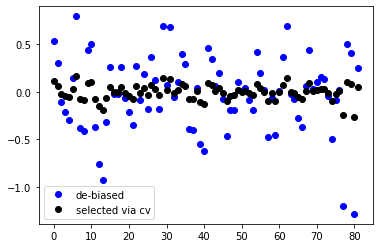

In [67]:
plt.figure()
plt.plot(cox_m.beta_db, 'bo', label = 'de-biased')
plt.plot(cox_m.beta_best, 'ko', label = 'selected via cv')
plt.legend()
plt.savefig('plot_beta_application.png')

In [68]:
omega = np.zeros(p)
for j in range(p):
    Xj = x[:,j] 
    filt_col = (np.arange(0, p, 1) != j)
    Z = x[:, filt_col]
    gamma = np.linalg.inv(np.transpose(Z) @ Z) @ (np.transpose(Z) @ Xj)
    omega[j] = np.sqrt( np.mean((Xj - Z @ gamma)**2) / (1- cox_m.zeta) )


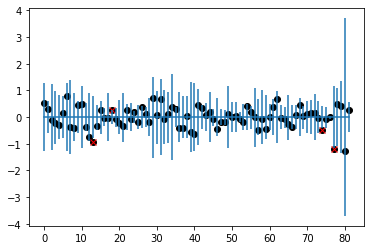

In [80]:
import scipy.stats as sps
dist = sps.norm(loc=0, scale=1)
std_db_res = cox_m.v_db / (omega * np.sqrt(p))
conf_regs = std_db_res * dist.ppf(0.5*(1.0 +0.99)) 
# flag = np.array(np.abs(cox_m.beta_db) >= std_db_res, int)
flag = (np.abs(cox_m.beta_db) > conf_regs)
plt.figure()
plt.plot(cox_m.beta_db, 'ko')
plt.plot(np.arange(p)[flag], cox_m.beta_db[flag], 'rx')
plt.errorbar(np.arange(p), np.zeros(p), yerr= conf_regs)
plt.savefig('plot_screening_beta_application.png')

In [83]:
print([cols_list[i] for i in range(p) if flag[i]==1])
print([cols_list[i] for i in idx[-4:]])

['X203391_at', 'X204540_at', 'X221916_at', 'er=positive']
['X201663_s_at', 'X203391_at', 'grade=unkown', 'er=positive']


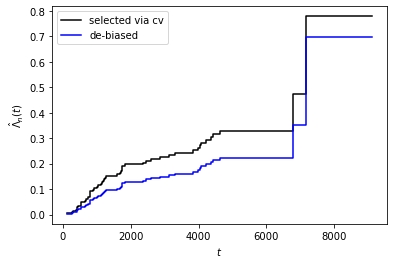

In [71]:
plt.figure()
cox_m.fit_frailty(cox_m.theta_est)
plt.plot(cox_m.t, cox_m.H_best, 'k-',ds = 'steps-post', label = 'selected via cv')
plt.plot(cox_m.t, cox_m.H_frailty, 'b-',ds = 'steps-post', label = 'de-biased')
plt.xlabel(r'$t$')
plt.ylabel(r'$\hat{\Lambda}_n(t)$')
plt.legend()
plt.savefig('H_application.png')

